# Initialization

In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")


!pip install torchsummary
!pip install thop

# Parameters
EPOCH = 50
lr = 0.01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data transformation

In [2]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# data augmentation & normalization
"""
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),

    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std)
])
"""

'\ntransform_train = transforms.Compose([\n    # data augmentation\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomCrop(32, padding=4),\n\n    transforms.ToTensor(),\n    # data normalization    # standardization: (image - train_mean) / train_std\n    transforms.Normalize(mean=train_mean, std=train_std)\n])\n\ntransform_test = transforms.Compose([\n    transforms.ToTensor(),\n    # data normalization    # standardization: (image - train_mean) / train_std\n    transforms.Normalize(mean=train_mean, std=train_std)\n])\n'

# Validation split and dataloader

In [74]:
BATCH_SIZE = 16

# dataset for training and validation
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# split dataset into trainset and validset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
valid_size = 5000       # 取5000張驗證集(0.1 of dataset)
train_size = len(dataset) - valid_size
trainset, validset = random_split(dataset, [train_size, valid_size])

# dataset for testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)   #生成batch 
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,drop_last=True, num_workers=2)

print("train length: ", len(trainset))
print("val length: ", len(validset))
print("test length: ", len(testset))

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


# Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


# Using ResNet-like neural network
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        #[channel, hieght, width]
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        #out[8,32,32]
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )
        #out[12,32,32]
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True)
        )
        #out[20,32,32]
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[32,16,16]
        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        )
        #out[32,16,16]
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        #out[48,16,16]
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[64,8,8]
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        #out[128,4,4]
        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        #out[128,4,4]
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(128, 10)
        )
        #out[10]
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res1(x) + x
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x) 
        x = self.res2(x) + x
        x = self.classifier(x)
        return x



# Parameters summary

In [5]:
from torchsummary import summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

net = ResNet().cuda()

grad_para = count_parameters(net)

# print(f'Total params: {grad_para / 1e6}M')
summary(net,(3,32,32))

#Compute MACs
from thop import profile

input1 = torch.randn(1,3,32,32).cuda() 
MACs, params = profile(net, inputs=(input1, ))

print('MACs = ' + str(MACs/1000**3) + 'G')

print('Params = ' + str(params/1000**2) + 'M')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4           [-1, 12, 32, 32]             876
       BatchNorm2d-5           [-1, 12, 32, 32]              24
              ReLU-6           [-1, 12, 32, 32]               0
            Conv2d-7           [-1, 20, 32, 32]           2,180
       BatchNorm2d-8           [-1, 20, 32, 32]              40
              ReLU-9           [-1, 20, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           5,792
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

# Train

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sch

net = ResNet().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)   # momentum-SGD，採用L2正則化（權重衰減）

"""
optimizer = optim.Adam(
          net.parameters(), 
          lr=0.001, 
          betas=(0.96, 0.9999), 
          amsgrad=True
      )
"""
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=1, epochs=EPOCH)

"""
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    #(Step decay)
    decay_rate = lr/(EPOCH)
    newlr = lr - decay_rate*epoch

    power = epoch // 5
    newlr = lr / pow(5, power)

    for param_group in optim.param_groups:    # change the lr to what you define
        param_group['lr'] = newlr
"""

train_loss, train_acc = [], []
val_loss, val_acc = [], []
lrs = []

for epoch in range(EPOCH):
    # train
    net.train()
    sum1_loss, sum2_loss = 0.0, 0.0
    correct = 0.0
    total = 0.0
    print('\nEpoch: %d' % (epoch + 1))
    for i, traindata in enumerate(trainloader, 0):
        # prepare data
        inputs, train_labels = traindata
        inputs, train_labels = inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        train_outputs = net(inputs)
        trainloss = criterion(train_outputs, train_labels)
        trainloss.backward()
        optimizer.step()

        # 每訓練1個batch的loss和acc
        sum1_loss += trainloss.item()
        _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels.data).cpu().sum()

    # learning rate schedule
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    #writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
    #adjust_learning_rate(optimizer, epoch)
    print("learning rate: ",  optimizer.param_groups[0]['lr'])
    
    loss1 = sum1_loss / (i + 1)
    acc1 = correct / total
    print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
    train_loss.append(loss1)
    train_acc.append(acc1.item())

    # 用val驗證
    with torch.no_grad():
        correct = 0
        total = 0
        for j, valdata in enumerate(validloader, 0):
            net.eval()
            images, val_labels = valdata
            images, val_labels = images.to(device), val_labels.to(device)
            val_outputs = net(images)
            valloss = criterion(val_outputs, val_labels)
                    
            sum2_loss += valloss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum()
                
        loss2 = sum2_loss / (j + 1)
        acc2 = correct / total
        print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
        val_loss.append(loss2)
        val_acc.append(acc2.item())


Epoch: 1
learning rate:  0.0052034602152724735
Train loss: 1.778 | Train acc: 0.369
Val loss: 1.458 | Val acc: 0.467

Epoch: 2
learning rate:  0.008753494340683884
Train loss: 1.101 | Train acc: 0.614
Val loss: 0.899 | Val acc: 0.684

Epoch: 3
learning rate:  0.014472088841534572
Train loss: 0.869 | Train acc: 0.701
Val loss: 0.777 | Val acc: 0.733

Epoch: 4
learning rate:  0.022072489510780793
Train loss: 0.800 | Train acc: 0.726
Val loss: 0.825 | Val acc: 0.735

Epoch: 5
learning rate:  0.03117358052235722
Train loss: 0.793 | Train acc: 0.733
Val loss: 0.824 | Val acc: 0.730

Epoch: 6
learning rate:  0.04131899517009691
Train loss: 0.784 | Train acc: 0.738
Val loss: 0.921 | Val acc: 0.709

Epoch: 7
learning rate:  0.052000000000000005
Train loss: 0.764 | Train acc: 0.743
Val loss: 0.759 | Val acc: 0.751

Epoch: 8
learning rate:  0.0626810048299031
Train loss: 0.734 | Train acc: 0.757
Val loss: 0.876 | Val acc: 0.699

Epoch: 9
learning rate:  0.07282641947764279
Train loss: 0.717 | T

# Test accuracy

In [7]:
# 用test測試
with torch.no_grad():
    correct = 0
    total = 0
    sum3_loss = 0.0
    for k, testdata in enumerate(testloader, 0):
        net.eval()
        imgs, test_labels = testdata
        imgs, test_labels = imgs.to(device), test_labels.to(device)
        test_outputs = net(imgs)
        testloss = criterion(test_outputs, test_labels)
                    
        sum3_loss += testloss.item()
        _, predicted = torch.max(test_outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum()
                
    loss3 = sum3_loss / (k + 1)
    acc3 = correct / total
    print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

Test loss: 0.645 | Test acc: 0.865


# Plot

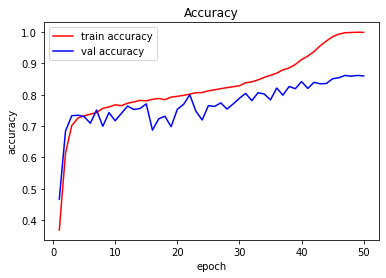

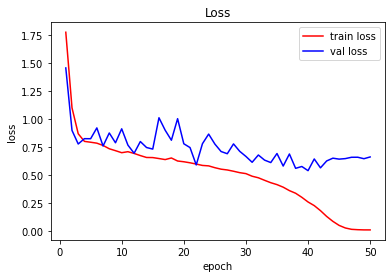

In [8]:
from matplotlib import pyplot as plt
import numpy as np
# plot accuracy curve
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy") 
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss") 
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Quantization Initialization

In [50]:
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, prepare_qat_fx
from torch.ao.quantization import QConfigMapping

# Setting Quantization Config

In [51]:
# set different quantization config

qconfig = get_default_qconfig('fbgemm')
""" (below is example of different configuration)
qconfig = get_default_qconfig("qnnpack")
qconfig = torch.ao.quantization.default_qconfig
qconfig = torch.ao.quantization.qconfig.QConfig(
    activation=torch.ao.quantization.observer.HistogramObserver.with_args(
        qscheme=torch.per_tensor_symmetric, 
        dtype=torch.qint8, 
    ),
    weight=torch.ao.quantization.observer.PerChannelMinMaxObserver.with_args(
        #ch_axis=1,  
        qscheme=torch.per_channel_symmetric,
        dtype=torch.qint8,
        ))
"""
qconfig_mapping = QConfigMapping().set_global(qconfig)

# Prepare Model

In [85]:
#device = 'cpu'
#model_to_quantize = net.to(device)
model_to_quantize.train()
example_inputs = (next(iter(trainloader))[0]) #to know model input data type
prepared_model = prepare_qat_fx(model_to_quantize, qconfig_mapping, example_inputs) # prepare to quantize model (fuse module (ex:CONV+BN+RELU...)，insert observer)

/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


# Train the Model

In [86]:
device = 'cpu'
optimizer = optim.SGD(prepared_model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)   # momentum-SGD，採用L2正則化（權重衰減）
for epoch in range(1):
    prepared_model.train()
    sum1_loss, sum2_loss = 0.0, 0.0
    correct = 0.0
    total = 0.0
    print('\nEpoch: %d' % (epoch + 1))
    for i, traindata in enumerate(trainloader, 0):
        # prepare data
        inputs, train_labels = traindata
        inputs, train_labels = inputs.to(device), train_labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        train_outputs = prepared_model(inputs)
        trainloss = criterion(train_outputs, train_labels)
        trainloss.backward()
        optimizer.step()

        # 每訓練1個batch的loss和acc
        sum1_loss += trainloss.item()
        _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels.data).cpu().sum()
    optimizer.step()
    
    loss1 = sum1_loss / (i + 1)
    acc1 = correct / total
    print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
    train_loss.append(loss1)
    train_acc.append(acc1.item())

    # 用val驗證
    with torch.no_grad():
        correct = 0
        total = 0
        for j, valdata in enumerate(validloader, 0):
            prepared_model.eval()
            images, val_labels = valdata
            images, val_labels = images.to(device), val_labels.to(device)
            val_outputs = prepared_model(images)
            valloss = criterion(val_outputs, val_labels)
                    
            sum2_loss += valloss.item()
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum()
                
        loss2 = sum2_loss / (j + 1)
        acc2 = correct / total
        print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
        val_loss.append(loss2)
        val_acc.append(acc2.item())


Epoch: 1
Train loss: 0.079 | Train acc: 0.971
Val loss: 0.726 | Val acc: 0.834


# Convert

In [87]:
prepared_model.eval()
quantized_model = convert_fx(prepared_model) # convert the calibrated model to a quantized model

# Check Quantized Model

In [88]:
print(model_to_quantize)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Seque

In [89]:
print(quantized_model)

GraphModule(
  (conv1): Module(
    (0): QuantizedConvReLU2d(3, 8, kernel_size=(3, 3), stride=(1, 1), scale=0.0836857333779335, zero_point=0, padding=(1, 1))
  )
  (conv2): Module(
    (0): QuantizedConvReLU2d(8, 12, kernel_size=(3, 3), stride=(1, 1), scale=0.07612984627485275, zero_point=0, padding=(1, 1))
  )
  (conv3): Module(
    (0): QuantizedConvReLU2d(12, 20, kernel_size=(3, 3), stride=(1, 1), scale=0.056256622076034546, zero_point=0, padding=(1, 1))
  )
  (conv4): Module(
    (0): QuantizedConvReLU2d(20, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0543966069817543, zero_point=0, padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Module(
    (0): Module(
      (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.02932540699839592, zero_point=0, padding=(1, 1))
    )
    (1): Module(
      (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05698072537779808, zero_poin

# Performance Analysis

In [90]:
import os
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [91]:
def compare(model, device, test_loader, quantize=False):
  model.to(device)
  model.eval()

  total = 0
  correct = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device),labels.to(device)
      outputs = model(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss = 0

  print("========================================= PERFORMANCE =============================================")
  print_size_of_model(model)
  print('\nAccuracy: {}/{} ({:.0f}%)\n'.format( correct, total,100. * correct / total))
  print("====================================================================================================") 

In [92]:
device = 'cpu'
print("Model to quantize")
compare(model=model_to_quantize, device=device, test_loader=testloader)

Model to quantize
========================================= PERFORMANCE =============================================
Size of the model(MB): 1.788101

Accuracy: 8407/10000 (84%)



In [93]:
device = 'cpu'
print("Quantized model")
compare(model=quantized_model, device=device, test_loader=testloader)

Quantized model
========================================= PERFORMANCE =============================================
Size of the model(MB): 0.472191

Accuracy: 8414/10000 (84%)

